<a href="https://colab.research.google.com/github/leo14993/analise-ligas-heas/blob/bsckup_antes_de_refatorar/Analise_HEAs_com_Feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importando as dependencias do projeto

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean
from matplotlib.ticker import PercentFormatter

#selecao e separação de dados
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    cross_val_predict
  )

#pre processamento de dados
from sklearn.preprocessing import (
    OneHotEncoder, 
    LabelEncoder, 
    OrdinalEncoder, 
    StandardScaler
  )

# avaliação resultados
from sklearn.metrics import (
    roc_curve,
    accuracy_score, 
    confusion_matrix,
    multilabel_confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay
  )

#modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans

from sklearn.model_selection import GridSearchCV 
from sklearn.feature_selection import SelectFromModel

#sobreamostragem
from imblearn.over_sampling import (
    SMOTE, 
    ADASYN,
    BorderlineSMOTE, 
    KMeansSMOTE, 
    SVMSMOTE
  )

import warnings
warnings.filterwarnings('ignore')

# ! pip install yellowbrick
# from yellowbrick.classifier import ROCAUC



## 2. Importando os dados e removendo colunas não utilizadas, e removendo linhas duplicadas

In [3]:
# caminho google colab
df = pd.read_csv('/content/drive/MyDrive/Documentos/TCC/HEAs_Machine_Learning/dados/df_final2.csv', error_bad_lines=False, sep=';')

# removendo os dados de componentes quimicos para gerar arquivo de analise
# apenas considerando as fases e outras variaveis
# df = df.drop(['Al','Co', 'Fe','Ni',	'Si','Cr','Mn','Nb',
#               'Mo','Ti','Cu','V','Zr','Ta','Hf','W' ],axis=1)

df.drop(['PROPERTY: Type of test', 'PROPERTY: YS (MPa)' , 'Alloy name', 'index'],axis=1, inplace=True)
# df = df.drop(['PROPERTY: Type of test', 'PROPERTY: YS (MPa)' ],axis=1)


* Etapa de analise de dados(opcional)

In [4]:
# jupyter
# !pip install pandas-profilling

# colab

#antes de executar o profile report é necessario reiniciar o ambiente de execução,
# instalar o pandas profiling para verificar a ausencia de alguma dependencia
# reiniciar novamente e importar 
# # ! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
# from pandas_profiling import ProfileReport

# # prof = ProfileReport(df)
# # prof.to_file(output_file='analise_dados_inicial.html')

# prof = ProfileReport(df_droped_duplicates)
# prof.to_file(output_file='analise_dados_inicial_sem_duplicados.html')


## 3. Conversão das variáveis categóricas em numeros inteiros / trocando valores nulos por zero

In [5]:
# Tornando variaveis categóricas em numeros ordinais

processing_method_ord_enc = \
  OrdinalEncoder().fit(df[['PROPERTY: Processing method']])
#   LabelEncoder().fit(df[['PROPERTY: Processing method']])


# alloy_name_ord_enc = OrdinalEncoder().fit(df[['Alloy name']])
microstructure_ord_enc = \
  OrdinalEncoder().fit(df[['PROPERTY: Microstructure']])
  # LabelEncoder().fit(df[['PROPERTY: Microstructure']])
  


df['PROPERTY: Processing method'] = \
  processing_method_ord_enc.transform(df[['PROPERTY: Processing method']])
# df['Alloy name'] = alloy_name_ord_enc.transform(df[['Alloy name']])
df['PROPERTY: Microstructure'] = \
  microstructure_ord_enc.transform(df[['PROPERTY: Microstructure']])

a = microstructure_ord_enc.inverse_transform(df[['PROPERTY: Microstructure']])


df.fillna(0,inplace=True)

df_droped_duplicates = df.drop_duplicates()
df_droped_duplicates.reset_index(inplace=True)

df_droped_duplicates.drop(['index'],axis=1, inplace=True)



## 3.1 Função para plotar matriz de confusão

In [6]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                          file_name=None,
                          show_accuracy=False):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    stats_text = ""
    
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if show_accuracy:
          if len(cf)==2:
              #Metrics for Binary Confusion Matrices
              precision = cf[1,1] / sum(cf[:,1])
              recall    = cf[1,1] / sum(cf[1,:])
              f1_score  = 2*precision*recall / (precision + recall)
              stats_text = "\n\nAcurácia={:0.3f}\nPrecisão={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                  accuracy,precision,recall,f1_score)
          else:
              stats_text = "\n\nAcurácia={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # --------------
    # cf_sum = np.sum(cf, axis=1, keepdims=True)
    # cf_perc = cf / cf_sum.astype(float) * 100
    # annot = np.empty_like(cf).astype(str)
    # nrows, ncols = cf.shape
    # for i in range(nrows):
    #     for j in range(ncols):
    #         c = cf[i, j]
    #         p = cf_perc[i, j]
    #         if i == j:
    #             s = cf_sum[i]
    #             annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
    #         #elif c == 0:
    #         #    annot[i, j] = ''
    #         else:
    #             annot[i, j] = '%.2f%%\n%d' % (p, c)
    # --------------------

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)

    image_plot = sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    

    if xyplotlabels:
        plt.ylabel('Microestruturas reais')
        plt.xlabel('Microestruturas previstas' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

    if file_name:
      plt.savefig(f'{file_name}.png')


In [7]:
def cm_analysis(y_true, y_pred, filename, labels, classes, ymap=None, figsize=(17,17), cmap="Blues"):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      classes:   aliases for the labels. String array to be shown in the cm plot.
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    sns.set(font_scale=1.1)

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%' % (p)
                # annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
            #elif c == 0:
            #    annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%' % (p)
                # annot[i, j] = '%.2f%%\n%d' % (p, c)

    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = cm * 100
    cm.index.name = 'Microestruturas reais'
    cm.columns.name = 'Microestruturas previstas'
    fig, ax = plt.subplots(figsize=figsize)
    
    # plt.yticks(va='center')

    sns.heatmap(cm, annot=annot, fmt='', ax=ax, xticklabels=classes, cbar=True, 
                cbar_kws={'format':PercentFormatter()}, 
                yticklabels=classes, cmap=cmap)
    plt.savefig(filename,  
                bbox_inches='tight'
                )

## 4. Separar o conjunto das variaveis e o conjunto dos alvos

In [29]:

#com duplicados
microstructure = df[['PROPERTY: Microstructure']]
properties = df[df.columns.difference(['PROPERTY: Microstructure'])]


#sem duplicados
microstructure_droped_duplicates = \
  df_droped_duplicates[['PROPERTY: Microstructure']]
properties_droped_duplicates = \
  df_droped_duplicates[df_droped_duplicates.columns.difference(
      ['PROPERTY: Microstructure']
  )]

x_train, x_test, y_train, y_test = train_test_split(
    properties,
    microstructure,
    test_size = 0.3,
    random_state = 388   
    )

x_train_droped_duplicates, x_test_droped_duplicates, \
y_train_droped_duplicates, y_test_droped_duplicates = train_test_split(
    properties_droped_duplicates,
    microstructure_droped_duplicates,
    test_size = 0.3,
    random_state = 388   
    )


# df_droped_duplicates.drop(['index'],axis=1, inplace=True)

x_train_droped_duplicates.reset_index(inplace=True)
x_train_droped_duplicates.drop(['index',],axis=1, inplace=True)
x_test_droped_duplicates.reset_index(inplace=True)
x_test_droped_duplicates.drop(['index',],axis=1, inplace=True)
y_train_droped_duplicates.reset_index(inplace=True)
y_train_droped_duplicates.drop(['index'],axis=1, inplace=True)
y_test_droped_duplicates.reset_index(inplace=True)
y_test_droped_duplicates.drop(['index'],axis=1, inplace=True)


k_folds = 10

n_validations = 10

In [9]:
x_test.shape

(177, 27)

###  5.1. Com duplicados

In [10]:
default_forest = RandomForestClassifier(random_state=54)

# microstructures = ['BCC','BCC ++','BCC B2','FCC','FCC ++','FCC BCC','OTHER']
microstructures = ['CCC','CCC ++','CCC B2','CFC','CFC ++','CFC CCC','OUTROS']

is_float = lambda x : x.replace('.','',1).isdigit()

inverse_transform_microstructure = \
  lambda x : microstructure_ord_enc.inverse_transform([[float(x)]])[0][0]

categorical_key = \
  lambda x : inverse_transform_microstructure(x) if is_float(x) else x

In [26]:
#1. predition with cross validation



def get_reports(x_train,y_train, models, k_folds=10):

  try:
    

    if type(models)!=list:
      models = [models]

    for model in models:
      print(str(model.__class__.__name__))

      y_train_pred = cross_val_predict(
          model, 
          x_train, 
          y_train.values.reshape(-1,), 
          cv=k_folds
        )

      #2. fitting model with all data
      default_forest_fit = model.fit(
          x_train, 
          y_train.values.reshape(-1,)
        )

      #3. Confusion matrix with Diagonal 
      confusion_matrix_microstructure = confusion_matrix(
            y_train, 
            y_train_pred
        )

      #4. confusion matrix with TP, TN, FP, FN
      multilabel_confusion_matrix_microstructure = \
        multilabel_confusion_matrix(y_train, y_train_pred)

      #5. get classification report 
      # with the report, we have a bigger picture, with precision and recall for each class
      clf_report = classification_report(
          y_train, 
          y_train_pred, 
          output_dict=True
        ) 

      f1_scores = []
      for i in clf_report:
        if is_float(i):
          f1_scores.append(clf_report[i]['f1-score'])
      print('media f1 scores: ',mean(f1_scores))

      # print(clf_report)
      #6. applyting name of microstructures on axis
      clf_report = {categorical_key(k):v for (k,v) in clf_report.items()}

      #7. creating dataframe
      df_classification_report = pd.DataFrame(clf_report).transpose()

      print('\n relatorio de dados com duplicados, n=', 
      properties.shape)
      print('\n', df_classification_report, '\n')
      # make_confusion_matrix(confusion_matrix_microstructure, 
      #                       figsize=(10,8), 
      #                       categories=microstructures,
      #                       cmap='Reds',
      #                       title='Dados completos')

      cm_analysis(y_train,
            y_train_pred, 'random forest', [0.0,1.0,2.0,3.0,4.0,5.0,6.0], microstructures, 
            figsize=(10,8),
              cmap="Reds")

  except Exception as err:
    print(err)

RandomForestClassifier
media f1 scores:  0.7405301344957921

 relatorio de dados com duplicados, n= (589, 27)

               precision    recall  f1-score     support
BCC            0.836066  0.902655  0.868085  113.000000
BCC ++         0.800000  0.701754  0.747664   57.000000
BCC B2         0.702703  0.812500  0.753623   32.000000
FCC            0.831579  0.822917  0.827225   96.000000
FCC ++         0.766667  0.779661  0.773109   59.000000
FCC BCC        0.700000  0.656250  0.677419   32.000000
OTHER          0.611111  0.478261  0.536585   23.000000
accuracy       0.788835  0.788835  0.788835    0.788835
macro avg      0.749732  0.736285  0.740530  412.000000
weighted avg   0.786608  0.788835  0.786098  412.000000 



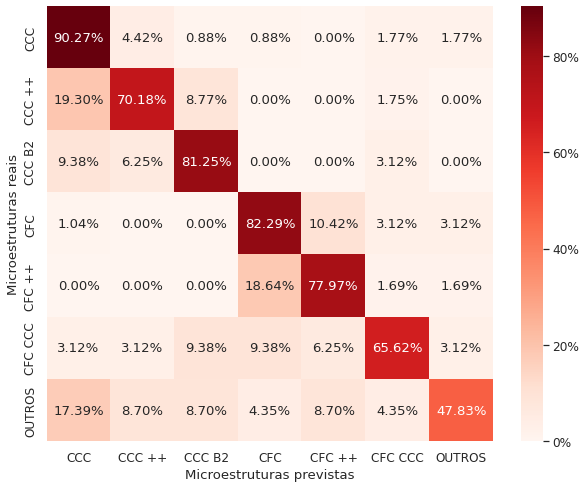

In [31]:
get_reports(x_train,y_train, default_forest)

# type(default_forest)

###  5.1. Sem duplicados

RandomForestClassifier
media f1 scores:  0.5995888746497793

 relatorio de dados com duplicados, n= (589, 27)

               precision    recall  f1-score     support
BCC            0.781609  0.906667  0.839506   75.000000
BCC ++         0.629630  0.459459  0.531250   37.000000
BCC B2         0.619048  0.565217  0.590909   23.000000
FCC            0.636364  0.552632  0.591549   38.000000
FCC ++         0.692308  0.658537  0.675000   41.000000
FCC BCC        0.530612  0.722222  0.611765   36.000000
OTHER          0.454545  0.294118  0.357143   17.000000
accuracy       0.662921  0.662921  0.662921    0.662921
macro avg      0.620588  0.594122  0.599589  267.000000
weighted avg   0.657494  0.662921  0.653404  267.000000 



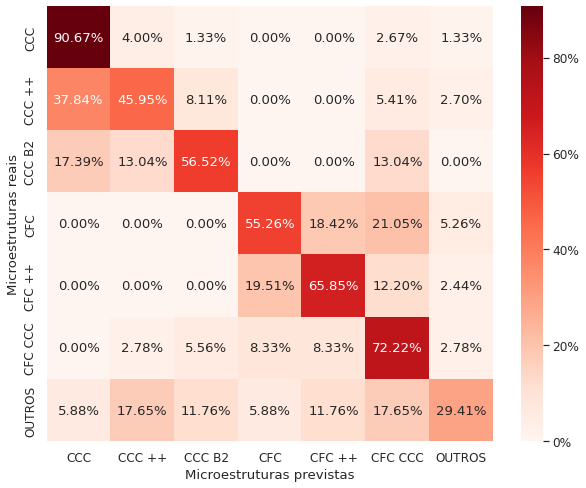

In [33]:

get_reports(x_train_droped_duplicates, y_train_droped_duplicates, default_forest)

In [32]:
#1. predition with cross validationx_train, 
    # y_train
y_train_pred_droped_duplicates = cross_val_predict(
    default_forest, 
    x_train_droped_duplicates,
    y_train_droped_duplicates.values.reshape(-1,),
    cv=k_folds
  )

#2. fitting model with duplicates removed
microstructure_confusion_matrix_droped_duplicates = \
  multilabel_confusion_matrix(
      y_train_droped_duplicates, 
      y_train_pred_droped_duplicates
  )

#3. Confusion matrix with Diagonal 
confusion_matrix_microstructure_droped_duplicates = confusion_matrix(
      y_train_droped_duplicates, 
      y_train_pred_droped_duplicates
  )

#4. confusion matrix with TP, TN, FP, FN
multilabel_confusion_matrix_microstructure_droped_duplicates = \
  multilabel_confusion_matrix(
      y_train_droped_duplicates, 
      y_train_pred_droped_duplicates
    )

#5. get classification report 
clf_report_droped_duplicates = classification_report(
    y_train_droped_duplicates, 
    y_train_pred_droped_duplicates, 
    output_dict=True
  )

f1_scores_droped_duplicates = []

for i in clf_report_droped_duplicates:
  if is_float(i):
    f1_scores_droped_duplicates.append(clf_report_droped_duplicates[i]['f1-score'])

print('media f1 scores: ',mean(f1_scores_droped_duplicates))
# print('media f1 scores: ',f1_scores_droped_duplicates)

#6. applyting name of microstructures on axis
clf_report_droped_duplicates = {categorical_key(k):v for (k,v) in clf_report_droped_duplicates.items()}

#7. creating dataframe
df_classification_report_droped_duplicates = pd.DataFrame(clf_report_droped_duplicates).transpose()



media f1 scores:  0.5995888746497793


### 5.3 Comparando dados de conjunto completo e sem duplicados

Conjunto de Dados Completo
- relatório com métricas
- Matriz de confusão

In [ ]:
print('\n relatorio de dados com duplicados, n=', 
      properties.shape)
print('\n', df_classification_report, '\n')
# make_confusion_matrix(confusion_matrix_microstructure, 
#                       figsize=(10,8), 
#                       categories=microstructures,
#                       cmap='Reds',
#                       title='Dados completos')

cm_analysis(y_train,
      y_train_pred, 'random forest', [0.0,1.0,2.0,3.0,4.0,5.0,6.0], microstructures, 
      figsize=(10,8),
        cmap="Reds")

Dados sem duplicados
- relatório com métricas
- Matriz de confusão



In [ ]:
print('\n relatorio de dados sem duplicados, n=', 
      properties_droped_duplicates.shape)
print('\n', df_classification_report_droped_duplicates, '\n')
# make_confusion_matrix(confusion_matrix_microstructure_droped_duplicates, 
#                       figsize=(10,8), 
#                       categories=microstructures,
#                       cmap='Reds',
#                       title='Dados duplicados removidos')

cm_analysis(y_train_droped_duplicates,
      y_train_pred_droped_duplicates, 'model_name', [0.0,1.0,2.0,3.0,4.0,5.0,6.0], microstructures, 
      figsize=(10,8),
        cmap="Reds")


## 6.0 Filtro Feature Selection

### 6.1 Obtendo variáveis do Fetarue Selection e removendo as desnecessárias

In [ ]:
nomes_propriedades = df.columns.difference(['PROPERTY: Microstructure'])

default_forest_fit = default_forest.fit(
      x_train_droped_duplicates,
      y_train_droped_duplicates.values.reshape(-1,)
      )

# Treinando o modelo para selecionar as colunas
filter_model = SelectFromModel(default_forest_fit, prefit=True)

#converter o Dataframe de treino e teste e remover colunas desnecessárias
x_train_droped_duplicates_featured = filter_model.transform(x_train_droped_duplicates)

x_train_droped_duplicates_featured = \
  pd.DataFrame(x_train_droped_duplicates_featured, 
  columns=filter_model.get_feature_names_out(input_features=nomes_propriedades)
)

x_test_droped_duplicates_featured = filter_model.transform(x_test_droped_duplicates)

x_test_droped_duplicates_featured = \
  pd.DataFrame(x_test_droped_duplicates_featured, 
  columns=filter_model.get_feature_names_out(input_features=nomes_propriedades)
)

In [ ]:
filter_model.get_feature_names_out(input_features=nomes_propriedades)


### 6.2 Varáveis utilizadas após o Feature selection

### 6.3 Comparando o desempenho do modelo após Feature selection

In [ ]:
#1. predition with cross validationx_train, 
    # y_train
microstructure_pred_droped_duplicates = cross_val_predict(
    default_forest, 
    x_train_droped_duplicates_featured,
    y_train_droped_duplicates.values.reshape(-1,),
    cv=k_folds
  )

#2. fitting model with duplicates removed
microstructure_confusion_matrix_droped_duplicates = \
  multilabel_confusion_matrix(
      y_train_droped_duplicates, 
      microstructure_pred_droped_duplicates
  )

#3. Confusion matrix with Diagonal 
confusion_matrix_microstructure_droped_duplicates = confusion_matrix(
      y_train_droped_duplicates, 
      microstructure_pred_droped_duplicates
  )

#4. confusion matrix with TP, TN, FP, FN
multilabel_confusion_matrix_microstructure_droped_duplicates = \
  multilabel_confusion_matrix(
      y_train_droped_duplicates, 
      microstructure_pred_droped_duplicates
    )

#5. get classification report 
clf_report_droped_duplicates = classification_report(
    y_train_droped_duplicates, 
    microstructure_pred_droped_duplicates, 
    output_dict=True
  )

f1_scores = []
for i in clf_report_droped_duplicates:
  if is_float(i):
    f1_scores.append(clf_report_droped_duplicates[i]['f1-score'])
print('media f1 scores: ',mean(f1_scores))

#6. applyting name of microstructures on axis
clf_report_droped_duplicates = {categorical_key(k):v for (k,v) in clf_report_droped_duplicates.items()}

#7. creating dataframe
df_classification_report_droped_duplicates = pd.DataFrame(clf_report_droped_duplicates).transpose()



### 6.3.1 Matriz de confusão dos dados com Feature Selection

In [ ]:
print('\n relatorio de dados utilizando Feature Selection, n=', 
      x_train_droped_duplicates.shape)
print('\n', df_classification_report_droped_duplicates, '\n')

print('\n')
print("{0:30} {1:30} {2}".format('modelo', 
                                  'acuracia', 
                                  'f1 scores'))
print("{0:30} {1:15} {2:30}".format(default_forest.__class__.__name__, 
                                  clf_report_droped_duplicates['accuracy'], 
                                  mean(f1_scores)))

# print( clf_report_droped_duplicates['accuracy'])

# print(mean(f1_scores))
  
# make_confusion_matrix(confusion_matrix_microstructure_droped_duplicates, 
#                       figsize=(10,8), 
#                       categories=microstructures,
#                       cmap='Reds',
#                       title='Dados duplicados removidos')

cm_analysis(y_train_droped_duplicates,
      microstructure_pred_droped_duplicates, 'feature_selection', [0.0,1.0,2.0,3.0,4.0,5.0,6.0], microstructures, 
      figsize=(10,8),
        cmap="Reds")

### 6.4 Validação do Feature Selection com o conjunto de teste

In [ ]:

homolog_fit = default_forest.fit(
    x_train_droped_duplicates_featured,
    y_train_droped_duplicates.values.reshape(-1,)
    )

caracteristic_homolog_pred = homolog_fit.predict(x_test_droped_duplicates_featured)

clf_report_oversampled_homolog = classification_report(
    y_test_droped_duplicates, 
    caracteristic_homolog_pred,
    output_dict=True
  )

microstructure_multilabel_confusion_matrix = \
  multilabel_confusion_matrix(
    y_test_droped_duplicates, 
    caracteristic_homolog_pred,
  )

microstructure_confusion_matrix = \
  confusion_matrix(
    y_test_droped_duplicates, 
    caracteristic_homolog_pred,
  )

clf_report = classification_report(
    y_test_droped_duplicates, 
    caracteristic_homolog_pred,
    output_dict=True
  )

f1_scores = []
for i in clf_report:
  if is_float(i):
    f1_scores.append(clf_report[i]['f1-score'])

# transform column index number to microstructure
clf_report = {categorical_key(k):v for (k,v) in clf_report.items()}

df_classification_report = pd.DataFrame(
    clf_report
  ).transpose()

model_name = str(default_forest.__class__.__name__)

print('Validação do Feature Selection utilizando o consjunto de teste')
# print(df_classification_report)

print('\n')
print("{0:30} {1:30} {2}".format('modelo', 
                                  'acuracia', 
                                  'f1 scores'))
print("{0:30} {1:15} {2:30}".format(model_name, 
                                clf_report['accuracy'], 
                                mean(f1_scores)))

print(df_classification_report)


cm_analysis(y_test_droped_duplicates,
      caracteristic_homolog_pred, 'feature_selection_validacao', [0.0,1.0,2.0,3.0,4.0,5.0,6.0], microstructures, 
      figsize=(10,8),
        cmap="Reds")

## 6. Normalização dos dados




> As colunas que possuem variaveis categóricas convertidas em numéricas, não precisam ser normalizadas, umas vez que que os valores são equidistantes. 

> Colunas dos elementos quimicos possuem seus valores em porcentagem, neste caso também não podem ser normalizados, quando normalizados perdem seu real significado e valor.

> Apenas os dados sem duplicados serão normalizados, uma vez que já foi feita uma comparação no bloco anterior.


In [ ]:
# #----------------------------------------------------------------
# # Normalizando os dados (sem feature Selection)
# #----------------------------------------------------------------


# properties_to_not_normalize = properties_droped_duplicates[['PROPERTY: Processing method',
#   'Al','Co', 'Fe','Ni',	'Si','Cr','Mn','Nb',
#   'Mo','Ti','Cu','V','Zr','Ta','Hf','W']]

# columns_to_normalize = properties_droped_duplicates.columns.difference([
#   'PROPERTY: Processing method',
#   'Al','Co', 'Fe','Ni',	'Si','Cr','Mn','Nb',
#   'Mo','Ti','Cu','V','Zr','Ta','Hf','W'])

# # -----------------

# properties_to_not_normalize = properties_droped_duplicates[[
#   'Al','Co', 'Fe','Ni',	'Si','Cr','Mn','Nb',
#   'Mo','Ti','Cu','V','Zr','Ta','Hf','W']]

# columns_to_normalize = properties_droped_duplicates.columns.difference([
  
#   'Al','Co', 'Fe','Ni',	'Si','Cr','Mn','Nb',
#   'Mo','Ti','Cu','V','Zr','Ta','Hf','W'])

# properties_to_normalize = properties_droped_duplicates[columns_to_normalize]

# # --------

# std_properties = StandardScaler().fit(properties_to_normalize)

# normalized_properties = std_properties.transform(properties_to_normalize)

# properties_droped_duplicates_normalized = \
#   pd.concat([pd.DataFrame(normalized_properties, columns=columns_to_normalize),
#             properties_to_not_normalize], 
#             axis=1
#   )

# # ------
# # properties_droped_duplicates_normalized = properties_to_not_normalize

# df_properties_droped_duplicates_normalized = pd.concat(
#     (properties_droped_duplicates_normalized,
#     microstructure_droped_duplicates),
#     axis=1
#     )

# x_train_normalized, x_test_normalized, y_train_normalized, y_test_normalized = \
#   train_test_split(
#     properties_droped_duplicates_normalized,
#     microstructure_droped_duplicates,
#     test_size = 0.3,
#     random_state = 388   
#     )


# # df_droped_duplicates.drop(['index'],axis=1, inplace=True)

# x_train_normalized.reset_index(inplace=True)
# x_train_normalized.drop(['index',],axis=1, inplace=True)
# x_test_normalized.reset_index(inplace=True)
# x_test_normalized.drop(['index',],axis=1, inplace=True)
# y_train_normalized.reset_index(inplace=True)
# y_train_normalized.drop(['index'],axis=1, inplace=True)
# y_test_normalized.reset_index(inplace=True)
# y_test_normalized.drop(['index'],axis=1, inplace=True)

In [ ]:
#----------------------------------------------------------------
# Normalizando os dados (sem feature Selection)
#----------------------------------------------------------------


# 'Cr', 'Fe', 'Ni', 'PROPERTY: Calculated Density (g/cm$^3$)',
#        'PROPERTY: Processing method', 'Tm', 'Xm', 'am', 'dT', 'dX', 'da',
#        'dr', 'rm'



properties_to_not_normalize = properties_droped_duplicates[['PROPERTY: Processing method',
'Cr', 'Fe', 'Ni']]

columns_to_normalize = properties_droped_duplicates.columns.difference([
  'PROPERTY: Processing method',
  'Cr', 'Fe', 'Ni'])

# -----------------

# properties_to_not_normalize = properties_droped_duplicates[[
#   'Al','Co', 'Fe','Ni',	'Si','Cr','Mn','Nb',
#   'Mo','Ti','Cu','V','Zr','Ta','Hf','W']]

# columns_to_normalize = properties_droped_duplicates.columns.difference([
  
#   'Al','Co', 'Fe','Ni',	'Si','Cr','Mn','Nb',
#   'Mo','Ti','Cu','V','Zr','Ta','Hf','W'])

properties_to_normalize = properties_droped_duplicates[columns_to_normalize]

# --------

std_properties = StandardScaler().fit(properties_to_normalize)

normalized_properties = std_properties.transform(properties_to_normalize)

properties_droped_duplicates_normalized = \
  pd.concat([pd.DataFrame(normalized_properties, columns=columns_to_normalize),
            properties_to_not_normalize], 
            axis=1
  )

# ------
# properties_droped_duplicates_normalized = properties_to_not_normalize

df_properties_droped_duplicates_normalized = pd.concat(
    (properties_droped_duplicates_normalized,
    microstructure_droped_duplicates),
    axis=1
    )

x_train_normalized, x_test_normalized, y_train_normalized, y_test_normalized = \
  train_test_split(
    properties_droped_duplicates_normalized,
    microstructure_droped_duplicates,
    test_size = 0.2,
    random_state = 388   
    )


# df_droped_duplicates.drop(['index'],axis=1, inplace=True)

x_train_normalized.reset_index(inplace=True)
x_train_normalized.drop(['index',],axis=1, inplace=True)
x_test_normalized.reset_index(inplace=True)
x_test_normalized.drop(['index',],axis=1, inplace=True)
y_train_normalized.reset_index(inplace=True)
y_train_normalized.drop(['index'],axis=1, inplace=True)
y_test_normalized.reset_index(inplace=True)
y_test_normalized.drop(['index'],axis=1, inplace=True)

### 6.1 Aplicando feature selection nos dados normalizados (nao aplicar)

In [ ]:
# nomes_propriedades = df.columns.difference(['PROPERTY: Microstructure'])

# default_forest_fit = default_forest.fit(
#       x_train_normalized,
#       y_train_normalized.values.reshape(-1,)
#       )

# # Treinando o modelo para selecionar as colunas
# filter_model = SelectFromModel(default_forest_fit, prefit=True)

# #converter o Dataframe de treino e teste e remover colunas desnecessárias
# x_train_normalized_filtered = filter_model.transform(x_train_normalized)

# x_train_normalized = \
#   pd.DataFrame(x_train_normalized_filtered, 
#   columns=filter_model.get_feature_names_out(input_features=nomes_propriedades)
# )

# x_test_normalized_filtered = filter_model.transform(x_test_normalized)

# x_test_normalized = \
#   pd.DataFrame( x_test_normalized, 
#   columns=filter_model.get_feature_names_out(input_features=nomes_propriedades)
# )

In [ ]:
filter_model.get_feature_names_out(input_features=nomes_propriedades)

### 6.1 Verificando influência da normalização no conjunto de dados

In [ ]:
microstructure_pred_droped_duplicates_normalized = cross_val_predict(
    default_forest, 
    x_train_normalized, 
    y_train_normalized.values.reshape(-1,), 
    cv=k_folds
  )

microstructure_confusion_matrix_droped_duplicates_normalized = \
  multilabel_confusion_matrix(
      y_train_normalized, 
      microstructure_pred_droped_duplicates_normalized
  )

clf_report_droped_duplicates_normalized = classification_report(
    y_train_normalized, 
    microstructure_pred_droped_duplicates_normalized,
    output_dict=True
  )

f1_scores = []
for i in clf_report_droped_duplicates_normalized:
  if is_float(i):
    f1_scores.append(clf_report_droped_duplicates_normalized[i]['f1-score'])
print('media f1 scores: ',mean(f1_scores))


# transform column index number to microstructure
clf_report_droped_duplicates_normalized = {categorical_key(k):v for (k,v) in clf_report_droped_duplicates_normalized.items()}

df_classification_report_droped_duplicates_normalized = pd.DataFrame(
    clf_report_droped_duplicates_normalized
  ).transpose()

# df_classification_report.index.names = ['microstructure']

cm_microstructure_droped_duplicates_normalized = confusion_matrix(
      y_train_normalized.values.reshape(-1,), 
      microstructure_pred_droped_duplicates_normalized
  )

In [ ]:
# media f1 scores:  0.5394325700973225
# media f1 scores norm :  0.5376535036701573

### 6.2 Dados não normalizados
- relatório com métricas
- Matriz de confusão

In [ ]:
# print('\n relatorio de dados não normalizados', 
#       properties_droped_duplicates.shape)
# print('\n', df_classification_report_droped_duplicates, '\n')
# # make_confusion_matrix(confusion_matrix_microstructure_droped_duplicates, 
# #                       figsize=(10,8), 
# #                       categories=microstructures,
# #                       cmap='Reds',
# #                       title='Dados não normalizados')

# cm_analysis(microstructure_droped_duplicates, 
#     microstructure_pred_droped_duplicates, 'random forest', [0.0,1.0,2.0,3.0,4.0,5.0,6.0], microstructures, 
#       figsize=(10,8),
#         cmap="Reds")
# cmd = ConfusionMatrixDisplay
# ConfusionMatrixDisplay.from_predictions(microstructure_droped_duplicates,microstructure_pred_droped_duplicates)


# -------------------


print('\n relatorio de dados utilizando Feature Selection, n=', 
      properties_droped_duplicates.shape)
print('\n', df_classification_report_droped_duplicates, '\n')

print('\n')
print("{0:30} {1:30} {2}".format('modelo', 
                                  'acuracia', 
                                  'f1 scores'))
print("{0:30} {1:15} {2:30}".format(default_forest.__class__.__name__, 
                                  clf_report_droped_duplicates['accuracy'], 
                                  mean(f1_scores)))

# print( clf_report_droped_duplicates['accuracy'])

# print(mean(f1_scores))
  
# make_confusion_matrix(confusion_matrix_microstructure_droped_duplicates, 
#                       figsize=(10,8), 
#                       categories=microstructures,
#                       cmap='Reds',
#                       title='Dados duplicados removidos')

cm_analysis(y_train_droped_duplicates,
      microstructure_pred_droped_duplicates, 'feature_selection', [0.0,1.0,2.0,3.0,4.0,5.0,6.0], microstructures, 
      figsize=(10,8),
        cmap="Reds")

### 6.3 Dados normalizados
- relatório com métricas
- Matriz de confusão

In [ ]:
print('\n relatorio de dados normalizados', 
      x_train_normalized.shape)
print('\n', df_classification_report_droped_duplicates_normalized, '\n')
# make_confusion_matrix(cm_microstructure_droped_duplicates_normalized, 
#                       figsize=(10,8), 
#                       categories=microstructures,
#                       cmap='Reds',
#                       title='Dados normalizados')

print('\n')
print("{0:30} {1:30} {2}".format('modelo', 
                                  'acuracia', 
                                  'f1 scores'))
print("{0:30} {1:15} {2:30}".format(default_forest.__class__.__name__, 
                                  clf_report_droped_duplicates_normalized['accuracy'], 
                                  mean(f1_scores)))

cm_analysis(y_train_normalized.values.reshape(-1,), 
      microstructure_pred_droped_duplicates_normalized, 'random forest', [0.0,1.0,2.0,3.0,4.0,5.0,6.0], microstructures, 
      figsize=(10,8),
        cmap="Reds")

# ConfusionMatrixDisplay.from_predictions(microstructure_droped_duplicates, microstructure_pred_droped_duplicates_normalized)

## Conclusão Normalização

Ocorreu um leve redução da acurácia, porém com a normalização de dados, foi removida a possibilidade de enviesar os resultados por conta de outliers

## 7. Comparando diferentes modelos

Nessa etapa são instanciados diversos modelos diferentes, e são comparados quais modelos performam melhor

In [ ]:

forest = RandomForestClassifier(random_state=54)
mlp = MLPClassifier(random_state=54)
knn = KNeighborsClassifier()
svm = SVC(random_state=54)

models= [
  forest, 
  mlp, 
  knn, 
  svm
]

cm_microstructure_models = {}

print("{0:30} {1:30} {2}".format('modelo', 
                                  'acuracia', 
                                  'f1 scores'))

for model in models:
  microstructure_pred = cross_val_predict(
      model, 
      properties_droped_duplicates_normalized,
      microstructure_droped_duplicates.values.reshape(-1,),
      cv=k_folds 
    )

  microstructure_multilabel_confusion_matrix = \
    multilabel_confusion_matrix(
        microstructure_droped_duplicates,
        microstructure_pred
    )
  
  microstructure_confusion_matrix = \
    confusion_matrix(
        microstructure_droped_duplicates,
        microstructure_pred
    )

  clf_report = classification_report(
      microstructure_droped_duplicates,
      microstructure_pred,
      output_dict=True
    )
  # print(clf_report.keys())
  
  f1_scores = []
  for i in clf_report:
    if is_float(i):
      f1_scores.append(clf_report[i]['f1-score'])

  # transform column index number to microstructure
  clf_report = {categorical_key(k):v for (k,v) in clf_report.items()}

  df_classification_report = pd.DataFrame(
      clf_report
    ).transpose()

  model_name = str(model.__class__.__name__)

  print('\n Model: ', model_name)
  print(df_classification_report)

  # print("{0:30} {1:15} {2:30}".format(model_name, 
  #                                 clf_report['accuracy'], 
  #                                 mean(f1_scores)))

  cm_microstructure_models[model_name] = \
    microstructure_confusion_matrix

  # make_confusion_matrix(microstructure_confusion_matrix, 
  #                       figsize=(10,8), 
  #                       categories=microstructures,cmap='Reds',
  #                       title=model_name,
  #                       count=False,
  #                       file_name=model_name)


  # cm_analysis(microstructure_droped_duplicates,
  #       microstructure_pred, model_name, [0.0,1.0,2.0,3.0,4.0,5.0,6.0], microstructures, 
  #       figsize=(10,8),
  #        cmap="Reds")

### 7.1 Avaliação utilizando conjunto de teste

Verificar os modelos usando dados de teste 

In [ ]:
cm_microstructure_models_hml = {}

print("{0:30} {1:30} {2}".format('modelo', 
                                  'acuracia', 
                                  'f1 scores'))

for model in models:

  homolog_fit = model.fit(
      x_train_normalized,
      y_train_normalized.values.reshape(-1,)
      )

  caracteristic_homolog_pred = homolog_fit.predict(x_test_normalized)

  clf_report_oversampled_homolog = classification_report(
      y_test_normalized, 
      caracteristic_homolog_pred,
      output_dict=True
    )

  microstructure_multilabel_confusion_matrix = \
    multilabel_confusion_matrix(
      y_test_normalized, 
      caracteristic_homolog_pred,
    )
  
  microstructure_confusion_matrix = \
    confusion_matrix(
      y_test_normalized, 
      caracteristic_homolog_pred,
    )

  clf_report = classification_report(
      y_test_normalized, 
      caracteristic_homolog_pred,
      output_dict=True
    )

  f1_scores = []
  for i in clf_report:
    if is_float(i):
      f1_scores.append(clf_report[i]['f1-score'])

  # transform column index number to microstructure
  clf_report = {categorical_key(k):v for (k,v) in clf_report.items()}

  df_classification_report = pd.DataFrame(
      clf_report
    ).transpose()

  model_name = str(model.__class__.__name__)

  print('\n Model: ', model_name)
  # print(df_classification_report)

  print('\n')
  print("{0:30} {1:15} {2:30}".format(model_name, 
                                  clf_report['accuracy'], 
                                  mean(f1_scores)))

  cm_microstructure_models[model_name] = \
    microstructure_confusion_matrix

  make_confusion_matrix(microstructure_confusion_matrix, 
                        figsize=(10,8), 
                        categories=microstructures,cmap='Reds',
                        title=model_name)

### 7.2 Conclusão avaliação dos modelos

Após avaliar o desempenho de diferentes modelos para o conjunto de dados sem duplicados, verificou-se a melhor performance do modelo radom forest, baseado na analise conjunta da acuracia, com f1 score.

## 8. Criando sobreamostragem 



> Essa etapa se baseia na utilização de modelos para gerar novos dados para treinamento do modelo, de forma que possibilite uma dispersão dos dados, tornando o modelo mais genérico e reduzindo o overffiting do ajuste da curva.






In [ ]:
samplers = [
    SMOTE(random_state=54),
    ADASYN(random_state=54),
    BorderlineSMOTE(random_state=54),
    KMeansSMOTE(random_state=54),
    SVMSMOTE(random_state=54),
]


data_oversampled = {}

frequencia_treino = y_train_normalized['PROPERTY: Microstructure'].value_counts()
percentual_treino = y_train_normalized['PROPERTY: Microstructure'].value_counts(normalize = True)*100

print('distribuição dos dados nao sobreamostrados')
dist_freq_qualitativas = pd.DataFrame({'Qtd': frequencia_treino, 
                                        '(%)': percentual_treino})



dist_freq_qualitativas.rename(index = {
    0.0: 'CCC', 
    1.0: 'CCC++',
    2.0: 'CCC B2',
    3.0: 'CFC',
    4.0: 'CFC++',
    5.0: 'CFC CCC',
    6.0: 'Outros'}, inplace = True)

print(dist_freq_qualitativas)

for sampler in samplers:

  properties_train_oversampled, microstructure_train_oversampled = \
    sampler.fit_resample(x_train_normalized, 
    y_train_normalized.values.reshape(-1,)
    )

  properties_train_oversampled = pd.DataFrame(
      properties_train_oversampled, 
      columns=x_train_normalized.columns
    )

  microstructure_train_oversampled = pd.DataFrame(
      microstructure_train_oversampled, 
      columns=['PROPERTY: Microstructure']
    )

  data_oversampled[str(sampler.__class__.__name__)] = {
      'properties_train_oversampled': properties_train_oversampled,
      'microstructure_train_oversampled': microstructure_train_oversampled 
    }

  frequencia_treino = microstructure_train_oversampled['PROPERTY: Microstructure'].value_counts()
  percentual_treino = microstructure_train_oversampled['PROPERTY: Microstructure'].value_counts(normalize = True)*100

  print(f'distribuição dos dados {str(sampler.__class__.__name__)}')
  dist_freq_qualitativas = pd.DataFrame({'Qtd': frequencia_treino, 
                                         '(%)': percentual_treino})
  
  
  
  dist_freq_qualitativas.rename(index = {
      0.0: 'CCC', 
      1.0: 'CCC++',
      2.0: 'CCC B2',
      3.0: 'CFC',
      4.0: 'CFC++',
      5.0: 'CFC CCC',
      6.0: 'Outros'}, inplace = True)

  print(dist_freq_qualitativas)

In [ ]:
microstructure_train_oversampled.shape

### 8.1 Verificando o desempenho dos diferentes tipos de sobre amostragem 
> Através do cross validation, será verificado o comportamento dos diferentes tipos de modelos de sobre amostragem, utilizando apenas o classificador random forest.

In [ ]:
# properties_oversampled, microstructure_oversampled
from statistics import mean
cm_microstructure_oversampled = {}



for oversampled in data_oversampled.keys():
  microstructure_pred_oversampled = cross_val_predict(
      default_forest, 
      data_oversampled[oversampled]['properties_train_oversampled'], 
      data_oversampled[oversampled]['microstructure_train_oversampled'],
      cv=k_folds
    )

  microstructure_multilabel_confusion_matrix_oversampled = \
    multilabel_confusion_matrix(
        data_oversampled[oversampled]['microstructure_train_oversampled'], 
        microstructure_pred_oversampled
    )
  
  microstructure_confusion_matrix_oversampled = \
    confusion_matrix(
        data_oversampled[oversampled]['microstructure_train_oversampled'], 
        microstructure_pred_oversampled
    )

  clf_report_oversampled = classification_report(
      data_oversampled[oversampled]['microstructure_train_oversampled'], 
      microstructure_pred_oversampled,
      output_dict=True
    )
  
  f1_scores = []
  for i in clf_report_oversampled:
    if is_float(i):
      f1_scores.append(clf_report_oversampled[i]['f1-score'])
  print('media f1 scores: ',mean(f1_scores))

  # transform column index number to microstructure
  clf_report_oversampled = {categorical_key(k):v for (k,v) in clf_report_oversampled.items()}

  df_classification_report_oversampled = pd.DataFrame(
      clf_report_oversampled
    ).transpose()

  print('Sampler: ',oversampled)
  print(df_classification_report_oversampled)

  cm_microstructure_oversampled[oversampled] = \
    microstructure_confusion_matrix_oversampled

  # make_confusion_matrix(microstructure_confusion_matrix_oversampled, 
  #                       figsize=(7,7), 
  #                       categories=microstructures,cmap='Reds',
  #                       title=oversampled)

  print('\n')

In [ ]:
default_forest = RandomForestClassifier()

cm_microstructure_oversampled_homolog = {}

for oversampled in data_oversampled.keys():
  

  homolog_fit = default_forest.fit(
      data_oversampled[oversampled]['properties_train_oversampled'], 
      data_oversampled[oversampled]['microstructure_train_oversampled']
      )

# y_train_normalized
  caracteristic_homolog_pred = homolog_fit.predict(x_test_normalized)

  clf_report_oversampled_homolog = classification_report(
      y_test_normalized, 
      caracteristic_homolog_pred,
      output_dict=True
    )

  f1_scores = []
  for i in clf_report_oversampled_homolog:
    if is_float(i):
      f1_scores.append(clf_report_oversampled_homolog[i]['f1-score'])
  print('media f1 scores: ',mean(f1_scores))

  # transform column index number to microstructure
  clf_report_oversampled_homolog = {categorical_key(k):v for (k,v) in clf_report_oversampled_homolog.items()}

  df_classification_report_oversampled_homolog = pd.DataFrame(
      clf_report_oversampled_homolog
    ).transpose()

  print('Sampler: ',oversampled)
  print(df_classification_report_oversampled_homolog)

  cm_microstructure_oversampled_homolog[oversampled] = confusion_matrix(
      y_test_droped_duplicates, 
      caracteristic_homolog_pred,
  )

  # make_confusion_matrix(cm_microstructure_oversampled_homolog[oversampled], 
  #                       figsize=(7,7), 
  #                       categories=microstructures,cmap='Reds',
  #                       title=oversampled)

  print('\n')

## 8.2 Validando modelos e sobreamostragens pela acurácia e média de F1 scores

### 8.2.1 Avaliando modelos nos diferentes tipos de sobreamostragem com cross-validation

In [ ]:
# properties_oversampled, microstructure_oversampled
print('dados  sobreamostrados Cross validation')

cm_microstructure_oversampled = {}

models = [models[0]]

for model in models:

  model_name = str(model.__class__.__name__)
  print('\n')
  print("{0:30} {1:30} {2}".format(model_name, 
                                  'acuracia', 
                                  'f1 scores'))

  for oversampled in data_oversampled.keys():
  
    
    microstructure_pred_oversampled = cross_val_predict(
        model, 
        data_oversampled[oversampled]['properties_train_oversampled'], 
        data_oversampled[oversampled]['microstructure_train_oversampled'],
        cv=15
      )

    microstructure_multilabel_confusion_matrix_oversampled = \
      multilabel_confusion_matrix(
          data_oversampled[oversampled]['microstructure_train_oversampled'], 
          microstructure_pred_oversampled
      )
    
    microstructure_confusion_matrix_oversampled = \
      confusion_matrix(
          data_oversampled[oversampled]['microstructure_train_oversampled'], 
          microstructure_pred_oversampled
      )

    clf_report_oversampled = classification_report(
        data_oversampled[oversampled]['microstructure_train_oversampled'], 
        microstructure_pred_oversampled,
        output_dict=True
      )
    
    f1_scores = []
    for i in clf_report_oversampled:
      if is_float(i):
        f1_scores.append(clf_report_oversampled[i]['f1-score'])

    # transform column index number to microstructure
    clf_report_oversampled = {categorical_key(k):v for (k,v) in clf_report_oversampled.items()}

    df_classification_report_oversampled = pd.DataFrame(
        clf_report_oversampled
      ).transpose()

    print("{0:30} {1:15} {2:30}".format(oversampled, 
                                  clf_report_oversampled['accuracy'], 
                                  mean(f1_scores)))

    cm_microstructure_oversampled[oversampled] = \
      microstructure_confusion_matrix_oversampled

    # make_confusion_matrix(microstructure_confusion_matrix_oversampled, 
    #                       figsize=(7,7), 
    #                       categories=microstructures,cmap='Reds',
    #                       title=f'{oversampled} - {model_name}')

    cm_analysis(data_oversampled[oversampled]['microstructure_train_oversampled'], 
          microstructure_pred_oversampled, oversampled, [0.0,1.0,2.0,3.0,4.0,5.0,6.0], microstructures, 
      figsize=(10,8),
        cmap="Reds")


### 8.2.2 Validando diferentes modelos com diferentes sobreamostragem com os dados de teste

In [ ]:
# default_forest = RandomForestClassifier()
print('validacao dados sobreamostrados')

cm_microstructure_oversampled_homolog = {}

for model in models:

  model_name = str(model.__class__.__name__)
  print('\n')
  print("{0:30} {1:30} {2}".format(model_name, 
                                  'acuracia', 
                                  'f1 scores'))

  for oversampled in data_oversampled.keys():

    homolog_fit = model.fit(
        data_oversampled[oversampled]['properties_train_oversampled'], 
        data_oversampled[oversampled]['microstructure_train_oversampled']
        )

    caracteristic_homolog_pred = homolog_fit.predict(x_test_normalized)

    clf_report_oversampled_homolog = classification_report(
        y_test_normalized, 
        caracteristic_homolog_pred,
        output_dict=True
      )

    f1_scores = []
    for i in clf_report_oversampled_homolog:
      if is_float(i):
        f1_scores.append(clf_report_oversampled_homolog[i]['f1-score'])

    # transform column index number to microstructure
    clf_report_oversampled_homolog = {categorical_key(k):v for (k,v) in clf_report_oversampled_homolog.items()}

    df_classification_report_oversampled_homolog = pd.DataFrame(
        clf_report_oversampled_homolog
      ).transpose()


    print("{0:30} {1:15} {2:30}".format(oversampled, 
                                  clf_report_oversampled_homolog['accuracy'], 
                                  mean(f1_scores)))

    cm_microstructure_oversampled_homolog[oversampled] = confusion_matrix(
        y_test_droped_duplicates, 
        caracteristic_homolog_pred,
    )

    # make_confusion_matrix(cm_microstructure_oversampled_homolog[oversampled], 
    #                       figsize=(7,7), 
    #                       categories=microstructures,cmap='Reds',
    #                       title=f'{oversampled} - {model_name}')
    

### 8.2.3 Conclusão comparação de modelos e sobreamostragens

Após a avaliação dos modelos em conjunto com o tipo de sobreamostragem, ficou claro que o modelo Random Forest em conjunto com a sobreamostragem BorderlineSMOTE  apresentaram os melhores resultados.

Sendo assim, a próxima etapa será analizar a melhor combinação de hiperparâmetros.

In [ ]:
best_oversampled = 'BorderlineSMOTE'

## 9 Avaliando hiperparâmetros dos modelos

Nesta etapa, serão avaliados os melhores hiperparâmetros para o modelo RandoForest, considerando os dados sobre amostrados, e os dados originais sem duplicados e normalizados.

### 9.2 Otimizando hiperparâmetros dos dados sobreamostrados

In [ ]:
parameters = {
    'criterion': ['entropy', 'gini'],
    'n_estimators': [21,22,23,24,190,195,200],
    'max_depth': [6,7,9,11,12,13,14,15],
    'max_features': ['auto']
} 

# oversamplers = ['SMOTE', 'ADASYN', 'BorderlineSMOTE', 'KMeansSMOTE', 'SVMSMOTE']

oversampled = 'BorderlineSMOTE'

regressor = GridSearchCV(RandomForestClassifier(random_state=54), parameters, verbose=1,cv=10,n_jobs=-1) 

# for oversampled in oversamplers:

regressor.fit(data_oversampled[best_oversampled]['properties_train_oversampled'].to_numpy(), 
      data_oversampled[best_oversampled]['microstructure_train_oversampled'].to_numpy()) 

  # print(oversampled)
print(regressor.best_params_)
# regressor.best_params_

Histórico de busca por melhores parametros

In [ ]:
# Fitting 10 folds for each of 40 candidates, totalling 400 fits
# GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=54),
#              n_jobs=-1,
#              param_grid={'criterion': ['entropy', 'gini'],
#                          'max_depth': [11, 12, 13, 14, 15],
#                          'max_features': ['auto'],
#                          'n_estimators': [21, 22, 23, 24]},
#              verbose=1)

# Fitting 10 folds for each of 24 candidates, totalling 240 fits
# GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=54),
#              n_jobs=-1,
#              param_grid={'criterion': ['entropy', 'gini'],
#                          'max_depth': [11, 12, 13, 15],
#                          'max_features': ['auto'],
#                          'n_estimators': [20, 23, 24]},
#              verbose=1)

# Fitting 10 folds for each of 24 candidates, totalling 240 fits
# GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=54),
#              n_jobs=-1,
#              param_grid={'criterion': ['entropy', 'gini'],
#                          'max_depth': [12, 15, 17], 'max_features': ['auto'],
#                          'n_estimators': [12, 15, 20, 23]},
#              verbose=1)

# Fitting 10 folds for each of 70 candidates, totalling 700 fits
# GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=54),
#              n_jobs=-1,
#              param_grid={'criterion': ['entropy', 'gini'],
#                          'max_depth': [6, 10, 12, 15, 18],
#                          'max_features': ['auto'],
#                          'n_estimators': [1, 10, 20, 25, 30, 50, 60]},
#              verbose=1)


Uma vez que os hiperparâmetros foram otimizados, é realizada a etapa para verificar o comportamento do modelo em conjuntos de dados simulados com composições variaveis

### 9.2.1 Avaliando hiperparâmetros através do cross validation 

In [ ]:
model_hyperparams_adjusted =  RandomForestClassifier(
    max_depth=15,
    random_state=54, 
    criterion='entropy', 
    max_features='auto',
    n_estimators = 22,
    )


# properties_oversampled, microstructure_oversampled
print('dados  sobreamostrados Cross validation (hiperparametros)')

cm_microstructure_oversampled = {}

models = [models[0]]

for model in [model_hyperparams_adjusted]:

  model_name = str(model.__class__.__name__)
  print('\n')
  print("{0:30} {1:30} {2}".format(model_name, 
                                  'acuracia', 
                                  'f1 scores'))

  for oversampled in [best_oversampled]:
  
    
    microstructure_pred_oversampled = cross_val_predict(
        model, 
        data_oversampled[oversampled]['properties_train_oversampled'], 
        data_oversampled[oversampled]['microstructure_train_oversampled'],
        cv=15
      )

    microstructure_multilabel_confusion_matrix_oversampled = \
      multilabel_confusion_matrix(
          data_oversampled[oversampled]['microstructure_train_oversampled'], 
          microstructure_pred_oversampled
      )
    
    microstructure_confusion_matrix_oversampled = \
      confusion_matrix(
          data_oversampled[oversampled]['microstructure_train_oversampled'], 
          microstructure_pred_oversampled
      )

    clf_report_oversampled = classification_report(
        data_oversampled[oversampled]['microstructure_train_oversampled'], 
        microstructure_pred_oversampled,
        output_dict=True
      )
    
    f1_scores = []
    for i in clf_report_oversampled:
      if is_float(i):
        f1_scores.append(clf_report_oversampled[i]['f1-score'])

    # transform column index number to microstructure
    clf_report_oversampled = {categorical_key(k):v for (k,v) in clf_report_oversampled.items()}

    df_classification_report_oversampled = pd.DataFrame(
        clf_report_oversampled
      ).transpose()

    print("{0:30} {1:15} {2:30}".format(oversampled, 
                                  clf_report_oversampled['accuracy'], 
                                  mean(f1_scores)))

    cm_microstructure_oversampled[oversampled] = \
      microstructure_confusion_matrix_oversampled

    # make_confusion_matrix(microstructure_confusion_matrix_oversampled, 
    #                       figsize=(7,7), 
    #                       categories=microstructures,cmap='Reds',
    #                       title=f'{oversampled} - {model_name}')

    cm_analysis(data_oversampled[oversampled]['microstructure_train_oversampled'], 
          microstructure_pred_oversampled, oversampled, [0.0,1.0,2.0,3.0,4.0,5.0,6.0], microstructures, 
      figsize=(8,8),
        cmap="Reds")


### 9.2.2 Validando hiperparâmetros do modelo com dados sobreamostrados usando dados de teste

In [ ]:
# properties_oversampled, microstructure_oversampled
print('dados  sobreamostrados Cross validation')

cm_microstructure_oversampled = {}

models = [models[0]]

for model in models:

  model_name = str(model.__class__.__name__)
  print('\n')
  print("{0:30} {1:30} {2}".format(model_name, 
                                  'acuracia', 
                                  'f1 scores'))

  for oversampled in data_oversampled.keys():
  
    
    microstructure_pred_oversampled = cross_val_predict(
        model, 
        data_oversampled[oversampled]['properties_train_oversampled'], 
        data_oversampled[oversampled]['microstructure_train_oversampled'],
        cv=15
      )

    microstructure_multilabel_confusion_matrix_oversampled = \
      multilabel_confusion_matrix(
          data_oversampled[oversampled]['microstructure_train_oversampled'], 
          microstructure_pred_oversampled
      )
    
    microstructure_confusion_matrix_oversampled = \
      confusion_matrix(
          data_oversampled[oversampled]['microstructure_train_oversampled'], 
          microstructure_pred_oversampled
      )

    clf_report_oversampled = classification_report(
        data_oversampled[oversampled]['microstructure_train_oversampled'], 
        microstructure_pred_oversampled,
        output_dict=True
      )
    
    f1_scores = []
    for i in clf_report_oversampled:
      if is_float(i):
        f1_scores.append(clf_report_oversampled[i]['f1-score'])

    # transform column index number to microstructure
    clf_report_oversampled = {categorical_key(k):v for (k,v) in clf_report_oversampled.items()}

    df_classification_report_oversampled = pd.DataFrame(
        clf_report_oversampled
      ).transpose()

    print("{0:30} {1:15} {2:30}".format(oversampled, 
                                  clf_report_oversampled['accuracy'], 
                                  mean(f1_scores)))

    cm_microstructure_oversampled[oversampled] = \
      microstructure_confusion_matrix_oversampled

    # make_confusion_matrix(microstructure_confusion_matrix_oversampled, 
    #                       figsize=(7,7), 
    #                       categories=microstructures,cmap='Reds',
    #                       title=f'{oversampled} - {model_name}')

    cm_analysis(data_oversampled[oversampled]['microstructure_train_oversampled'], 
          microstructure_pred_oversampled, oversampled, [0.0,1.0,2.0,3.0,4.0,5.0,6.0], microstructures, 
      figsize=(8,8),
        cmap="Reds")


### 9.3 Avaliação dos hiperparâmetros nos dados sem sobreamostragem

In [ ]:
parameters = {
    'max_depth': [13,14,15],
    'criterion': ['gini'],
    'n_estimators': [199,200],
    
    'max_features': ['auto']
}


# oversamplers = ['SMOTE', 'ADASYN', 'BorderlineSMOTE', 'KMeansSMOTE', 'SVMSMOTE']

oversampled = 'KMeansSMOTE'

regressor = GridSearchCV(RandomForestClassifier(random_state=54), parameters, verbose=1,cv=10,n_jobs=-1) 

# for oversampled in oversamplers:

regressor.fit(properties_droped_duplicates_normalized.to_numpy(), 
      microstructure_droped_duplicates) 


# ajustar hiperparametros considerando dados do conjunto de teste



  # print(oversampled)
print(regressor.best_params_)

In [ ]:
microstructure_droped_duplicates.shape

In [ ]:
model_hyperparams_adjusted =  RandomForestClassifier(
    max_depth=13,
    random_state=54, 
    criterion='gini', 
    max_features='auto',
    n_estimators = 195,
    )


# model_hyperparams_adjusted =  RandomForestClassifier(
#     max_depth=100,
#     criterion='entropy',
#     random_state=54
#     )

microstructure_pred = cross_val_predict(
    model_hyperparams_adjusted, 
    properties_droped_duplicates_normalized,
    microstructure_droped_duplicates.values.reshape(-1,),
    cv=k_folds 
  )

microstructure_multilabel_confusion_matrix = \
  multilabel_confusion_matrix(
      microstructure_droped_duplicates,
      microstructure_pred
  )

microstructure_confusion_matrix = \
  confusion_matrix(
      microstructure_droped_duplicates,
      microstructure_pred
  )

clf_report = classification_report(
    microstructure_droped_duplicates,
    microstructure_pred,
    output_dict=True
  )

# transform column index number to microstructure
clf_report = {categorical_key(k):v for (k,v) in clf_report.items()}

df_classification_report = pd.DataFrame(
    clf_report
  ).transpose()

model_name = str(model_hyperparams_adjusted.__class__.__name__)

print('\n Model: ', model_name)
print(df_classification_report)

# cm_microstructure_models[model_name] = \
#   microstructure_confusion_matrix

# make_confusion_matrix(microstructure_confusion_matrix, 
#                       figsize=(10,8), 
#                       categories=microstructures,cmap='Reds',
#                       title=model_name)

# cm_analysis(microstructure_droped_duplicates,
#       microstructure_pred, model_name, [0.0,1.0,2.0,3.0,4.0,5.0,6.0], microstructures, 
#       figsize=(8,7),
#         cmap="Reds")

In [ ]:
#  Model:  RandomForestClassifier
#               precision    recall  f1-score     support
# BCC            0.691667  0.775701  0.731278  107.000000
# BCC ++         0.555556  0.378788  0.450450   66.000000
# BCC B2         0.473684  0.580645  0.521739   31.000000
# FCC            0.493333  0.596774  0.540146   62.000000
# FCC ++         0.595238  0.471698  0.526316   53.000000
# FCC BCC        0.560976  0.547619  0.554217   42.000000
# OTHER          0.380952  0.380952  0.380952   21.000000
# accuracy       0.573298  0.573298  0.573298    0.573298
# macro avg      0.535915  0.533168  0.529300  382.000000
# weighted avg   0.573441  0.573298  0.567569  382.000000

In [ ]:
simple_forest = RandomForestClassifier(
    max_depth=13,
    random_state=54, 
    criterion='gini', 
    max_features='auto',
    n_estimators = 195,
    )

microstructure_pred_droped_duplicates_normalized = cross_val_predict(
    simple_forest, 
    properties_droped_duplicates_normalized, 
    microstructure_droped_duplicates.values.reshape(-1,), 
    cv=k_folds
  )

microstructure_confusion_matrix_droped_duplicates_normalized = \
  multilabel_confusion_matrix(
      microstructure_droped_duplicates, 
      microstructure_pred_droped_duplicates_normalized
  )

clf_report_droped_duplicates_normalized = classification_report(
    microstructure_droped_duplicates, 
    microstructure_pred_droped_duplicates_normalized,
    output_dict=True
  )

# transform column index number to microstructure
clf_report_droped_duplicates_normalized = {categorical_key(k):v for (k,v) in clf_report_droped_duplicates_normalized.items()}

df_classification_report_droped_duplicates_normalized = pd.DataFrame(
    clf_report_droped_duplicates_normalized
  ).transpose()

# df_classification_report.index.names = ['microstructure']

cm_microstructure_droped_duplicates_normalized = confusion_matrix(
      microstructure_droped_duplicates.values.reshape(-1,), 
      microstructure_pred_droped_duplicates_normalized
  )


print('\n relatorio de dados normalizados', 
      properties_droped_duplicates_normalized.shape)
print('\n', df_classification_report_droped_duplicates_normalized, '\n')
make_confusion_matrix(cm_microstructure_droped_duplicates_normalized, 
                      figsize=(10,8), 
                      categories=microstructures,
                      cmap='Reds',
                      title='Dados normalizados')

## Resultados dos hiperparâmetros otimizados validando com cross validation do conjunto de treino

In [ ]:
# optimized_forest = RandomForestClassifier(
#     random_state=54,
#     criterion='gini', max_depth=13, max_features='auto', n_estimators=200 )

optimized_forest = RandomForestClassifier(
    max_depth=13,
    random_state=54, 
    criterion='gini', 
    max_features='auto',
    n_estimators = 195,
    )

oversampled='KMeansSMOTE'


model_name = str(optimized_forest.__class__.__name__)

microstructure_pred_oversampled = cross_val_predict(
    optimized_forest, 
    data_oversampled[oversampled]['properties_train_oversampled'], 
    data_oversampled[oversampled]['microstructure_train_oversampled'],
    cv=10
  )

microstructure_confusion_matrix_oversampled = \
  confusion_matrix(
      data_oversampled[oversampled]['microstructure_train_oversampled'], 
      microstructure_pred_oversampled
  )

clf_report_oversampled = classification_report(
    data_oversampled[oversampled]['microstructure_train_oversampled'], 
    microstructure_pred_oversampled,
    output_dict=True
  )

f1_scores = []
for i in clf_report_oversampled:
  if is_float(i):
    f1_scores.append(clf_report_oversampled[i]['f1-score'])

# transform column index number to microstructure
clf_report_oversampled = {categorical_key(k):v for (k,v) in clf_report_oversampled.items()}

df_classification_report_oversampled = pd.DataFrame(
    clf_report_oversampled
  ).transpose()

print("{0:30} {1:15} {2:30}".format(oversampled, 
                              clf_report_oversampled['accuracy'], 
                              mean(f1_scores)))

cm_microstructure_oversampled[oversampled] = \
  microstructure_confusion_matrix_oversampled

print('\n Model: ', model_name)
print(df_classification_report_oversampled)

## Resultados dos hiperparâmetros otimizados validando com conjunto de teste

In [ ]:
optimized_forest = RandomForestClassifier(random_state=54)
    # random_state=54,
    # criterion='gini', max_depth=13, max_features='auto', n_estimators=200 )


# optimized_forest = RandomForestClassifier(
#     random_state=54,
#     criterion='entropy', max_depth=5, max_features=None, n_estimators=500 )

# Fitting 10 folds for each of 792 candidates, totalling 7920 fits
# {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'n_estimators': 500}

oversampled='KMeansSMOTE'
model_name = optimized_forest.__class__.__name__

homolog_fit = optimized_forest.fit(
        data_oversampled[oversampled]['properties_train_oversampled'], 
        data_oversampled[oversampled]['microstructure_train_oversampled']
        )

caracteristic_homolog_pred = homolog_fit.predict(x_test_normalized)

clf_report_oversampled_homolog = classification_report(
    y_test_normalized, 
    caracteristic_homolog_pred,
    output_dict=True
  )

f1_scores = []
for i in clf_report_oversampled_homolog:
  if is_float(i):
    f1_scores.append(clf_report_oversampled_homolog[i]['f1-score'])

# transform column index number to microstructure
clf_report_oversampled_homolog = {categorical_key(k):v for (k,v) in clf_report_oversampled_homolog.items()}

df_classification_report_oversampled_homolog = pd.DataFrame(
    clf_report_oversampled_homolog
  ).transpose()


print("{0:30} {1:15} {2:30}".format(oversampled, 
                              clf_report_oversampled_homolog['accuracy'], 
                              mean(f1_scores)))

cm_microstructure_oversampled_homolog[oversampled] = confusion_matrix(
    y_test_droped_duplicates, 
    caracteristic_homolog_pred,
)

print('\n Model: ', model_name)
print(df_classification_report_oversampled_homolog)

In [ ]:
import numpy as np
def rd(n, total_sum):
    nums = np.random.rand(n)
    return nums/np.sum(nums)*total_sum

n = rd(16,1)



In [ ]:
n

In [ ]:
# n_elements = random.randint(3, 5)
import random
# composition = rd(n_elements,1)

my_list = list([i for i in range(16)])
random.shuffle(my_list)

print(my_list)
print(my_list[random.randint(0, 15)])

In [ ]:
import pandas as pd

df_teste = pd.DataFrame([n], columns=properties_droped_duplicates.columns)

my_list = list([i for i in range(16)])

for i in range(500):

  n_elements = random.randint(3, 5)
  composition = rd(n_elements,1)

  composition_final = [0] * 16
  
  random.shuffle(my_list)

  for j in composition:
    composition_final[my_list[random.randint(0, 15)]] = j
    


  new_row = pd.Series(composition_final, index = df_teste.columns)
  df_teste = df_teste.append(new_row, ignore_index=True)

print(df_teste)

In [ ]:
caracteristic_teste_predict[1]

In [ ]:
# caracteristic_teste_predict = homolog_fit.predict(x_test_normalized)

caracteristic_teste_predict = homolog_fit.predict(df_teste)
print(caracteristic_teste_predict)

micros_teste = [microstructure_ord_enc.inverse_transform([[k]])[0][0] for k in caracteristic_teste_predict]

print(micros_teste)
# x_test_normalized
# df_teste

In [ ]:
print(caracteristic_teste_predict)
print(x_test_normalized)